# Deep Learning & Art: Neural Style Transfer
This notebook contains an implementation of Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**Learning goals:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images
- Define the style cost function for Neural Style Transfer
- Define the content cost function for Neural Style Transfer

Many machine learning algorithms optimize a cost function to get a set of parameter values. With Neural Style Transfer, we will optimize a cost function to get pixel values.

## Table of Contents

- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - Transfer Learning](#3)
- [4 - Neural Style Transfer (NST)](#4)
    - [4.1 - Computing the Content Cost](#4-1)
        - [4.1.1 - Make Generated Image G Match the Content of Image C](#4-1-1)
        - [4.1.2 - Content Cost Function  𝐽𝑐𝑜𝑛𝑡𝑒𝑛𝑡(𝐶,𝐺)](#4-1-2)
            - [compute_content_cost](#ex-1)
    - [4.2 - Computing the Style Cost](#4-2)
        - [4.2.1 - Style Matrix](#4-2-1)
            - [gram_matrix](#ex-2)
        - [4.2.2 - Style Cost](#4-2-2)
            - [compute_layer_style_cost](#ex-3)
        - [4.2.3 Style Weights](#4-2-3)
            - [compute_style_cost](#ex-4)
    - [4.3 - Defining the Total Cost to Optimize](#4-3)
        - [total_cost](#ex-5)
- [5 - Solving the Optimization Problem](#5)
    - [5.1 Load the Content Image](#5-1)
    - [5.2 Load the Style Image](#5-2)
    - [5.3 Randomly Initialize the Image to be Generated](#5-3)
    - [5.4 - Load Pre-trained VGG19 Model](#5-4)
    - [5.5 - Compute Total Cost](#5-5)
        - [5.5.1 - Compute Content Cost](#5-5-1)
        - [5.5.2 - Compute Style Cost](#5-5-2)
            - [train_step](#ex-6)
    - [5.6 - Train the Model](#5-6)
- [6 - Test With Your Own Image (Optional/Ungraded)](#6)
- [7 - References](#7)




<a name='1'></a>
## 1 - Packages

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint

%matplotlib inline

<a name='2'></a>
## 2 - Algorithm overview

Neural Style Transfer (NST) merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S.

See example below, taken from the paper:

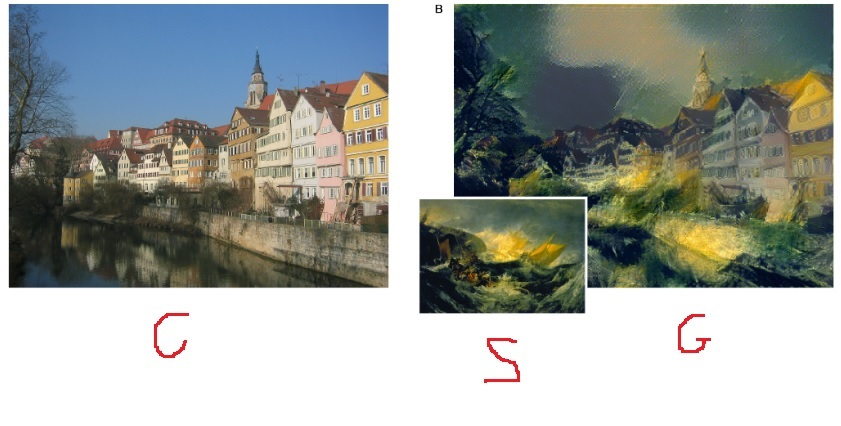

In [5]:
from IPython.display import Image as ImShow

PATH = "C:/Users/krist/Google Drive/Machine Learning/Coursera/CNNs/Neural Style Transfer/"
ImShow(filename = PATH + "Example.jpg")

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

We will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

The following code loads parameters from the VGG model.

In [6]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.vgg19.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)

The Neural Style Transfer (NST) algorithm is built in three steps:

- First, the content cost function $J_{content}(C,G)$
- Second, the style cost function $J_{style}(S,G)$
- Finally, put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Make Generated Image G Match the Content of Image C

One goal when performing NST is for the content in generated image G to match the content of image C. To do so, let's look at  <b> shallow versus deep layers </b>:

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

#### To choose a "middle" activation layer $a^{[l]}$ :
You need the "generated" image G to have similar content as the input image C. Suppose you have chosen some layer's activations to represent the content of an image. 
* In practice, you'll get the most visually pleasing results if you choose a layer in the <b>middle</b> of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.
* We can experiment with using different layers to see how the results vary.

#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the layer you had chosen. This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
This is defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 
* For clarity, note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 



<a name='ex-1'></a>
### compute_content_cost function

For this we use TensorFlow. 

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

The 3 steps to implement this function are:
1. Retrieve dimensions from `a_G`, using: `X.get_shape().as_list()`
2. Unroll `a_C` and `a_G`
    - You'll likely want to use these functions: [tf.transpose](https://www.tensorflow.org/api_docs/python/tf/transpose) and [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape).
3. Compute the content cost:
    - You'll likely want to use these functions: [tf.reduce_sum](https://www.tensorflow.org/api_docs/python/tf/reduce_sum), [tf.square](https://www.tensorflow.org/api_docs/python/tf/square) and [tf.subtract](https://www.tensorflow.org/api_docs/python/tf/subtract).
    


In [7]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[1, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))/(4*n_H*n_W*n_C)
        
    return J_content

In [8]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
J_content_0 = compute_content_cost(a_C, a_C)
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

# Test that it works with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_content_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_content_cost\n")
    print(inst)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_content</b>  
        </td>
        <td>
            7.0568767
        </td>
    </tr>

</table>


  
**Key points:**
    
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- When you minimize the content cost later, this will help make sure $G$ has similar content as $C$. 


<a name='4-2'></a>
### 4.2 - Computing the Style Cost

<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

* For the sake of clarity, in this assignment $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.


#### Compute Gram matrix $G_{gram}$
You will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

<a name='gram_matrix'></a>
### gram_matrix
* implementation using Tensorflow below to compute the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is $G_A = AA^T$. 

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  

    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [10]:
tf.random.set_seed(1)
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

assert type(GA) == EagerTensor, "Use the tensorflow function"
assert GA.shape == (3, 3), "Wrong shape. Check the order of the matmul parameters"
assert np.allclose(GA[0,:], [63.1888, -26.721275, -7.7320204]), "Wrong values."

print("GA = \n" + str(GA))

print("\033[92mAll tests passed")

GA = 
tf.Tensor(
[[ 63.1888    -26.721275   -7.7320204]
 [-26.721275   12.76758    -2.5158243]
 [ -7.7320204  -2.5158243  23.752384 ]], shape=(3, 3), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>GA</b>
        </td>
        <td>
           [[ 63.1888    -26.721275   -7.7320204] <br>
 [-26.721275   12.76758    -2.5158243] <br>
 [ -7.7320204  -2.5158243  23.752384 ]] <br>
        </td>
    </tr>

</table>

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

Now we minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, using only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$


<a name='compute_layer_style_cost'></a>
### compute_layer_style_cost
Compute the style cost for a single layer. 


In [11]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S), shape=[n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G), shape=[n_C, n_H * n_W])
    
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    divider = 4 * pow(n_C, 2) * pow(n_H * n_W, 2)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)))/divider
    
    return J_style_layer

In [12]:
tf.random.set_seed(1)
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


assert type(J_style_layer_GG) == EagerTensor, "Use the tensorflow functions"
assert np.isclose(J_style_layer_GG, 0.0), "Wrong value. compute_layer_style_cost(A, A) must be 0"
assert J_style_layer_SG > 0, "Wrong value. compute_layer_style_cost(A, B) must be greater than 0 if A != B"
assert np.isclose(J_style_layer_SG, 14.017805), "Wrong value."

print("J_style_layer = " + str(J_style_layer_SG))




J_style_layer = tf.Tensor(14.017808, shape=(), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J_style_layer</b>
        </td>
        <td>
           14.017805
        </td>
    </tr>

</table>

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* So far we have captured the style from only one layer. 
* We get better results by "merging" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* Experiment with different weights to see how it changes the generated image $G$.
* By default, give each layer equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Start by listing the layer names:

In [13]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Get a look at the output of a layer `block5_conv4`. You will later define this as the content layer, which will represent the image.

In [14]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now choose layers to represent the style of the image and assign style costs:

In [15]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


<a name='ex-4'></a>
### compute_style_cost

In [16]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        print(weight)
        print(weight[1])
        J_style += weight[1] * J_style_layer

    return J_style

How do you choose the coefficients for each layer? The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if you want the generated image to softly follow the style image, try choosing larger weights for deeper layers and smaller weights for the first layers. In contrast, if you want the generated image to strongly follow the style image, try choosing smaller weights for deeper layers and larger weights for the first layers.

<br>
   
**Key points:**
    
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- You get even better results by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 
   



<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

Below is a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [17]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style
    
    return J

In [18]:
#TESTING ONLY

J_content = 0.01    
J_style = 0.9
J = total_cost(J_content, J_style)

assert type(J) == EagerTensor, "Do not remove the @tf.function() modifier from the function"
# assert J == 34, "Wrong value. Try inverting the order of alpha and beta in the J calculation"
assert np.isclose(total_cost(0.3, 0.5, 3, 8), 4.9), "Wrong value. Use the alpha and beta parameters"

np.random.seed(1)
print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))

print("\033[92mAll tests passed")

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


**Expected Output**:

<table>
    <tr>
        <td>
            <b>J</b>
        </td>
        <td>
           32.9832
        </td>
    </tr>

</table>

<a name='5'></a>
## 5 - Solving the Optimization Problem

Now we pull everything together:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

<a id='part(4)'></a>

<a name='5-1'></a>
### 5.1 Load the Content Image
Run the following code cell to load, reshape, and normalize your "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


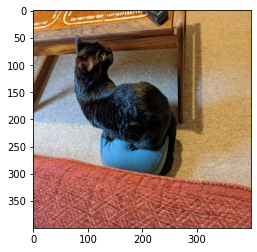

In [21]:
content_image = np.array(Image.open("C:/Users/krist/Google Drive/Machine Learning/Coursera/CNNs/Neural Style Transfer/Image folder/Georgie.jpg").resize((img_size, img_size)))
output_name = "TestOutput"
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image
Now load, reshape and normalize your "style" image (Claude Monet's painting):

(1, 400, 400, 3)


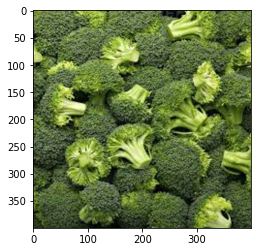

In [22]:
style_image = np.array(Image.open("C:/Users/krist/Google Drive/Machine Learning/Coursera/CNNs/Neural Style Transfer/Image folder/Broccoli.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
Initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


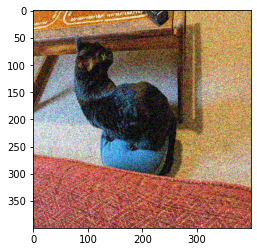

In [23]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model
Define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [24]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, define the content layer and build the model.

In [25]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)
print(vgg_model_outputs)

Save the outputs for the content and style layers in separate variables.

In [26]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

<a name='5-5'></a>
### 5.5 - Compute Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Compute the Content image Encoding (a_C)

In [27]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S) 

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [28]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that you will need to display the images generated by the style transfer model.

In [29]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='train_step'></a>
### train_step 

Implementation of the train_step() function for transfer learning

* Uses the Adam optimizer to minimize the total cost `J`.
* Uses a learning rate of 0.01  
* [Adam Optimizer documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
* You will use [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to update the image.
* Within the tf.GradientTape():
   * Compute the encoding of the generated image using vgg_model_outputs. Assing the result to a_G.
   * Compute the total cost J, using the global variables a_C, a_S and the local a_G
   * Can adjust alpha and beta

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [31]:
# You always must run the last cell before this one. You will get an error if not.
generated_image = tf.Variable(generated_image)


J1 = train_step(generated_image)
print(J1)
assert type(J1) == EagerTensor, f"Wrong type {type(J1)} != {EagerTensor}"
# assert np.isclose(J1, 25629.055, rtol=0.05), f"Unexpected cost for epoch 0: {J1} != {25629.055}"

J2 = train_step(generated_image)
print(J2)
# assert np.isclose(J2, 17812.627, rtol=0.05), f"Unexpected cost for epoch 1: {J2} != {17735.512}"

print("\033[92mAll tests passed")

('block1_conv1', 0.2)
0.2
('block2_conv1', 0.2)
0.2
('block3_conv1', 0.2)
0.2
('block4_conv1', 0.2)
0.2
('block5_conv1', 0.2)
0.2
('block1_conv1', 0.2)
0.2
('block2_conv1', 0.2)
0.2
('block3_conv1', 0.2)
0.2
('block4_conv1', 0.2)
0.2
('block5_conv1', 0.2)
0.2
tf.Tensor(27412.15, shape=(), dtype=float32)
tf.Tensor(15518.853, shape=(), dtype=float32)
All tests passed


**Expected output**
```
tf.Tensor(25629.055, shape=(), dtype=float32)
tf.Tensor(17735.512, shape=(), dtype=float32)
```

<a name='Train the Model'></a>
### Train the Model

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

Epoch 0 
Cost: 6979.6513671875


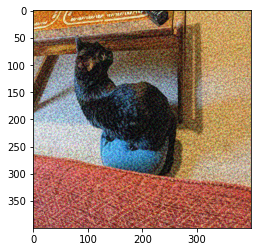

Epoch 5 
Epoch 10 
Epoch 15 
Epoch 20 
Epoch 25 
Cost: 299.97454833984375


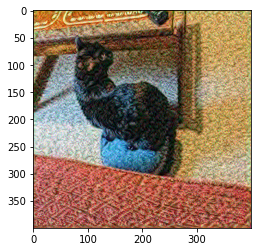

Epoch 30 
Epoch 35 
Epoch 40 
Epoch 45 
Epoch 50 
Cost: 101.76995086669922


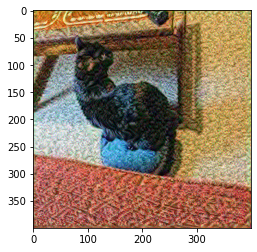

Epoch 55 
Epoch 60 
Epoch 65 
Epoch 70 
Epoch 75 
Cost: 60.760353088378906


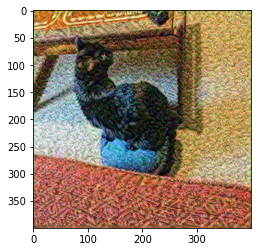

Epoch 80 
Epoch 85 
Epoch 90 
Epoch 95 
Epoch 100 
Cost: 44.783447265625


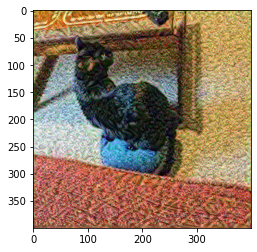

Epoch 105 
Epoch 110 
Epoch 115 
Epoch 120 
Epoch 125 
Cost: 36.070281982421875


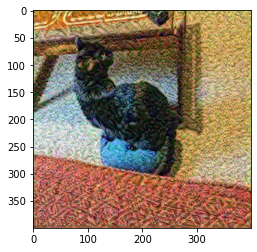

Epoch 130 
Epoch 135 
Epoch 140 
Epoch 145 
Epoch 150 
Cost: 30.439041137695312


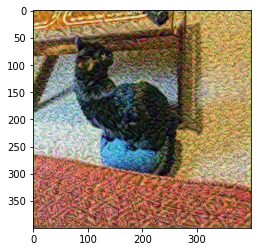

In [33]:
# Show the generated image at some epochs
def show_intermediate_output(cost, iteration, generated_image):
    print(f"Cost: {cost}")
    image = tensor_to_image(generated_image)
    imshow(image)
    image.save(f"C:/Users/krist/Google Drive/Machine Learning/Coursera/CNNs/Neural Style Transfer/Image folder/Outputs/{output_name}_{i}.jpg")
    plt.show()

# Uncoment to reset the style transfer process. You will need to compile the train_step function again
# image = tensor_to_image(generated_image)
# imshow(image) 
# plt.show()

coursera_epochs = 2501
custom_epochs = 151
custom_epoch_intermediate_output = 25
for i in range(custom_epochs):
    cost = train_step(generated_image)
    if i % 5 == 0:
        print(f"Epoch {i} ")
        if i % custom_epoch_intermediate_output == 0:
            show_intermediate_output(cost, i, generated_image)


Now, run the following code cell to see the results!

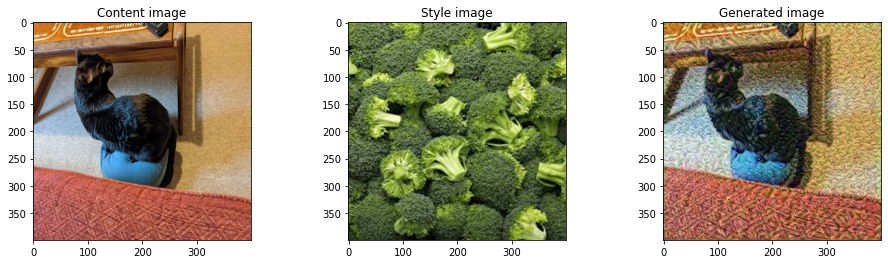

In [34]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

The hyperparameters are set so that we didn't have to wait too long to see an initial result. To get the best looking results, run the optimization algorithm longer (and with a smaller learning rate).

## Key points
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




<a name='7'></a>
## 7 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)
